# Stationary SCM and DAG (STAT.) from figure 1 in paper but with node out-degree $\geq 1$

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.utils.sequential_sampling import sequentially_sample_model
from src.examples.example_setups import setup_stat_multiple_children_scm
from src.utils.sem_utils.toy_sems import StationaryDependentMultipleChildrenSEM as TestSEM
from src.utils.sem_utils.sem_estimate import build_sem_hat
from src.utils.plotting import plot_outcome

from numpy.random import seed

# Models
from src.methods.cbo import CBO
from src.methods.dcbo import DCBO

seed(seed=0)

### Use reference DAG and with added arcs

In [2]:
T = 3

In [3]:
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, optimal_interventions, all_causal_effects  = setup_stat_multiple_children_scm(T=T)

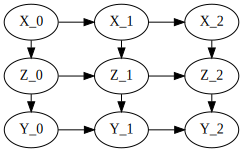

In [4]:
dag_view

This is not a complete representation, an extra arcs exists between $X_t$ and $Y_t$ in each slice.

In [5]:
D_O = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=10,
                                epsilon=None)
# Simulate some interventional data
from src.utils.utilities import powerset, get_monte_carlo_expectation
from src.utils.sequential_intervention_functions import make_sequential_intervention_dict
from numpy import zeros

D_I = {k: None for k in powerset(["X", "Z"])}
"""
do(Z_0)
"""
interv = make_sequential_intervention_dict(G,T)
# Univariate intervention at time 0
interv["Z"][0] = 1.0
static_noise_model = {k: zeros(T) for k in ["X", "Z", "Y"]}
# Sample this model with one intervention, and no noise
intervention_samples = sequentially_sample_model(
    init_sem,
    sem,
    total_timesteps=T,
    interventions=interv,
    sample_count=1,
    epsilon=static_noise_model
)

# Note: we obvs don't need to take MC samples if noise-model is zero
D_I[("Z",)] = get_monte_carlo_expectation(intervention_samples)

#### True outcomes

In [6]:
# Contains the exploration sets we will be investigating
print("Exploration sets:", exploration_sets)
# The intervention domains for the manipulative variables
print("Intervention domains:", intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print("True optimal outcome values:", [r"y^*_{} = {}".format(t,val.round(3)) for t,val in enumerate(true_objective_values)])
# Number of trials
N = 10

Exploration sets: [('X',), ('Z',), ('X', 'Z')]
Intervention domains: {'X': [-4, 1], 'Z': [-3, 3]}
True optimal outcome values: ['y^*_0 = -2.993', 'y^*_1 = -5.987', 'y^*_2 = -8.98']


In [7]:
print(true_objective_values)

[-2.9932977241366254, -5.986595448273251, -8.979893172409875]


# BO

In [8]:
from src.methods.bo import BO

BO_input_params = {
    "G": G,
    "sem": TestSEM, 
    "base_target_variable": "Y",
    # "exploration_sets":exploration_sets,
    "observation_samples": D_O,
    "intervention_domain": intervention_domain,
    "intervention_samples":None,
    "number_of_trials": N,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    # "debug_mode":True,
    # "ground_truth":all_causal_effects,
    # "exploration_sets":[('X',),("Z",)]
}
bo = BO(**BO_input_params)
bo.run()

Time index: 100%|██████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.51it/s]


In [ ]:
import numpy as np
print(bo.optimal_outcome_values_during_trials)
print('--------------------------------')
print(np.shape(bo.optimal_outcome_values_during_trials))
print('--------------------------------')
print(bo.optimal_outcome_values_during_trials[0][9])
bo_count=np.linspace(0,19,20,dtype=int)
bo_opts_def=[]

print('--------------------------------')
print('--------------------------------')

for i in bo_count:
    bo_opts_def.append(bo.optimal_outcome_values_during_trials[i][9])
    
print(bo_opts_def)
print('--------------------------------')
print(len(bo_opts_def))

[[-0.14395493940312776, -0.14395493940312776, -0.34605776017838064, -2.3414764533495065, -2.3414764533495065, -2.3414764533495065, -2.3414764533495065, -2.3414764533495065, -2.3414764533495065, -2.3414764533495065], [-2.485431392752634, -2.6875342135278872, -3.334954718627528, -3.334954718627528, -3.334954718627528, -4.811921005299469, -5.197713958816682, -5.215568438659819, -5.215568438659819, -5.215568438659819], [-5.3595233780629465, -5.3595233780629465, -5.750186618276643, -7.482950123147878, -8.071805944126995, -8.071805944126995, -8.071805944126995, -8.071805944126995, -8.071805944126995, -8.071805944126995]]
--------------------------------
(3, 10)
--------------------------------
-2.3414764533495065
--------------------------------
--------------------------------


### Causal Bayesian Optimization

In [ ]:

CBO_input_params = {
    "G": G,
    "sem": TestSEM, 
    "base_target_variable": "Y",
    "make_sem_estimator": build_sem_hat,
    "exploration_sets":exploration_sets,
    "observation_samples": D_O,
    "intervention_domain": intervention_domain,
    "intervention_samples":None,
    "number_of_trials": N,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    # "debug_mode":True,
    # "ground_truth":all_causal_effects,
    # "exploration_sets":[('X',),("Z",)]
}


In [ ]:
cbo = CBO(**CBO_input_params)
cbo.run()

In [ ]:
plot_outcome(T,N,
outcomes=[cbo.optimal_outcome_values_during_trials],labels=['CBO'], true_objective_values=true_objective_values)

# Dynamic causal Bayesian optimisation

In [ ]:
dcbo = DCBO(**CBO_input_params)
dcbo.run()

In [ ]:
dcbo.sem_trans_fncs

In [ ]:
plot_outcome(T,N,outcomes=[dcbo.optimal_outcome_values_during_trials],labels=['DCBO'], true_objective_values=true_objective_values)

In [ ]:
import numpy as np
print(dcbo.optimal_outcome_values_during_trials)
print('--------------------------------')
print(np.shape(dcbo.optimal_outcome_values_during_trials))
print('--------------------------------')
print(dcbo.optimal_outcome_values_during_trials[0][9])

print('--------------------------------')
print('--------------------------------')

count=np.linspace(0,19,20,dtype=int)
opts_def=[]

for i in count:
    opts_def.append(dcbo.optimal_outcome_values_during_trials[i][9])
    
print(opts_def)
print('--------------------------------')
print(len(opts_def))